# Bank Loan Status Prediction

### Brandon Lotus
#### - _Machine Learning and Evaluation_

_Sumber dataset: https://www.kaggle.com/zaurbegiev/my-dataset_

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sidetable
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
import joblib
import pickle
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('credit_clean.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Home Ownership,Purpose,Monthly Debt,Years of Credit History,Number of Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,Fully Paid,445412.0,Short Term,709.0,1167493.0,8,Home Mortgage,Home Improvements,5214.74,17.2,6.0,1,228190.0,416746.0,1,0
1,Fully Paid,262328.0,Short Term,726.0,1172718.0,10,Home Mortgage,Debt Consolidation,33295.98,21.1,35.0,0,229976.0,850784.0,0,0
2,Fully Paid,347666.0,Long Term,721.0,806949.0,3,Own Home,Debt Consolidation,8741.90,12.0,9.0,0,256329.0,386958.0,0,0
3,Fully Paid,176220.0,Short Term,726.0,1172718.0,5,Rent,Debt Consolidation,20639.70,6.1,15.0,0,253460.0,427174.0,0,0
4,Fully Paid,217646.0,Short Term,730.0,1184194.0,0,Home Mortgage,Debt Consolidation,10855.08,19.6,13.0,1,122170.0,272052.0,1,0


## Feature Engineering

In [5]:
# df['Number of Credit Problems'] = np.where(df['Number of Credit Problems'] == 0, 0, 1)
# df['Bankruptcies'] = np.where(df['Bankruptcies'] == 0, 0, 1)
# df['Tax Liens'] = np.where(df['Tax Liens'] == 0, 0, 1)

# kolom 'Number of Credit Problems', 'Bankruptcies' dan 'Tax Liens' sebelumnya sudah dibuat menjadi binari(0/1)
# karena nilai 0 jauh mendominasi jumlah data dibanding yang lain (sekitar 90% data)

In [3]:
df.stb.freq(['Purpose'], cum_cols = False)

# dari perbandingan tujuan peminjaman, terlihat debt consolidation jauh mendominasi (79%)

,Purpose,count,percent
0,Debt Consolidation,53473,79.084523
1,Other,6045,8.940324
2,Home Improvements,3944,5.833025
3,Business Loan,1220,1.804333
4,Buy a Car,871,1.288176
5,Medical Bills,719,1.063374
6,Buy House,431,0.637433
7,vacation,429,0.634475
8,major_purchase,247,0.365304
9,moving,93,0.137543


In [4]:
df['Purpose'] = np.where(df['Purpose'] == 'Debt Consolidation', 'Debt Consolidation', 'Other')
df.stb.freq(['Purpose'], cum_cols = False)

# kolom purpose dibuat menjadi 2 kategori (debt consolidation dan other)

,Purpose,count,percent
0,Debt Consolidation,53473,79.084523
1,Other,14142,20.915477


### Encoding

In [6]:
df['Loan Status'] = df['Loan Status'].map({'Charged Off': 0, 'Fully Paid': 1})
df['Term'] = df['Term'].map({'Short Term': 0, 'Long Term': 1})

# dilakukan label encoding untuk kolom loan status dan term karena data binary

In [7]:
df = pd.get_dummies(data = df, columns = ['Home Ownership'])
df = pd.get_dummies(data = df, columns = ['Purpose'])

# dilakukan one hot encoding dengan get_dummies untuk kolom home ownership dan purpose karena data bersifat nominal

In [8]:
df.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years in current job,Monthly Debt,Years of Credit History,Number of Open Accounts,Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent,Purpose_Debt Consolidation,Purpose_Other
0,1,445412.0,0,709.0,1167493.0,8,5214.74,17.2,6.0,1,228190.0,416746.0,1,0,1,0,0,0,1
1,1,262328.0,0,726.0,1172718.0,10,33295.98,21.1,35.0,0,229976.0,850784.0,0,0,1,0,0,1,0
2,1,347666.0,1,721.0,806949.0,3,8741.90,12.0,9.0,0,256329.0,386958.0,0,0,0,1,0,1,0
3,1,176220.0,0,726.0,1172718.0,5,20639.70,6.1,15.0,0,253460.0,427174.0,0,0,0,0,1,1,0
4,1,217646.0,0,730.0,1184194.0,0,10855.08,19.6,13.0,1,122170.0,272052.0,1,0,1,0,0,1,0


### Feature Selection

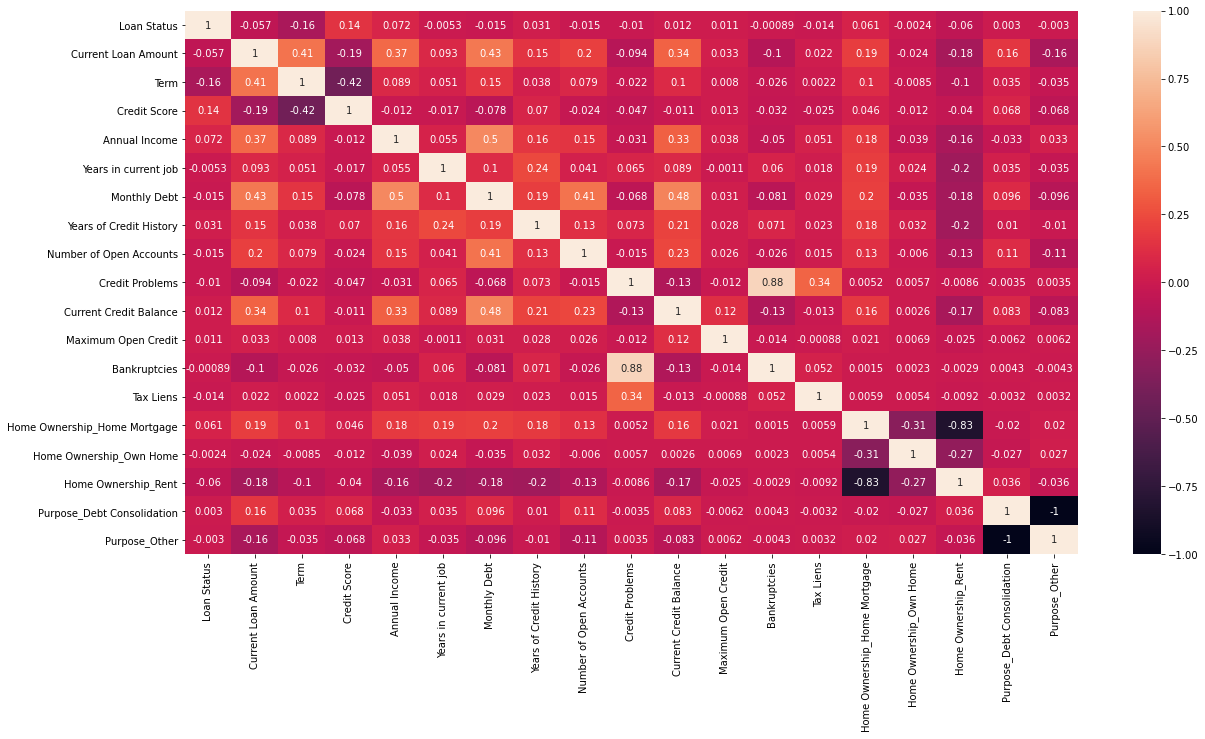

In [9]:
plt.figure(figsize = (20, 10))
sns.heatmap(df.corr(), annot=True)
plt.show()

# setelah encode data, dapat dilihat korelasi antar kolom untuk feature selection

In [10]:
df.corr()['Loan Status'].sort_values(ascending = False)[1:]

# korelasi antara features dan kolom target (loan status) tertinggi credit score (0,144) dan term (-0,156)
# features yang hanya memiliki korelasi sekitar 0.01 atau dibawahnya tidak digunakan dalam ml

Credit Score                    0.144282
Annual Income                   0.072041
Home Ownership_Home Mortgage    0.060584
Years of Credit History         0.031073
Current Credit Balance          0.011675
Maximum Open Credit             0.010621
Purpose_Debt Consolidation      0.003008
Bankruptcies                   -0.000891
Home Ownership_Own Home        -0.002419
Purpose_Other                  -0.003008
Years in current job           -0.005253
Credit Problems                -0.010465
Tax Liens                      -0.014191
Number of Open Accounts        -0.015310
Monthly Debt                   -0.015416
Current Loan Amount            -0.057251
Home Ownership_Rent            -0.059945
Term                           -0.156395
Name: Loan Status, dtype: float64

In [11]:
df.drop(['Current Credit Balance','Maximum Open Credit','Purpose_Debt Consolidation','Purpose_Other','Bankruptcies',
         'Years in current job','Credit Problems','Tax Liens','Number of Open Accounts','Monthly Debt'],axis=1,inplace=True)
df.head()

,Loan Status,Current Loan Amount,Term,Credit Score,Annual Income,Years of Credit History,Home Ownership_Home Mortgage,Home Ownership_Own Home,Home Ownership_Rent
0,1,445412.0,0,709.0,1167493.0,17.2,1,0,0
1,1,262328.0,0,726.0,1172718.0,21.1,1,0,0
2,1,347666.0,1,721.0,806949.0,12.0,0,1,0
3,1,176220.0,0,726.0,1172718.0,6.1,0,0,1
4,1,217646.0,0,730.0,1184194.0,19.6,1,0,0


### Data Split

In [12]:
X = df.drop(columns='Loan Status')
y = df['Loan Status']
X_train, X_test, y_train, y_test = train_test_split(X ,y ,stratify = y, train_size=.80, random_state=42)

### Handling Imbalance

In [14]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 42)

# menggunakan metode smote untuk menyamakan jumlah data kelas majority dan minority

In [15]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [16]:
df_smote = pd.concat([X_train_sm, y_train_sm], axis = 1)
df_smote['Loan Status'].value_counts()

1    39655
0    39655
Name: Loan Status, dtype: int64

### Scaling

In [17]:
scaler_ro = RobustScaler()
X_train_sm_ro = scaler_ro.fit_transform(X_train_sm)
X_test_ro = scaler_ro.transform(X_test)

# scaling untuk algorithm berbasis distance menggunakan robust scaler karena terdapat outliers

### Logistic Regression Base

In [51]:
lr_base = LogisticRegression()
lr_base.fit(X_train_sm_ro, y_train_sm)

LogisticRegression()

In [52]:
pred_lr_base = lr_base.predict(X_test_ro)

In [53]:
print(classification_report(y_test, pred_lr_base))

              precision    recall  f1-score   support

           0       0.40      0.20      0.27      3609
           1       0.75      0.89      0.82      9914

    accuracy                           0.71     13523
   macro avg       0.58      0.55      0.54     13523
weighted avg       0.66      0.71      0.67     13523



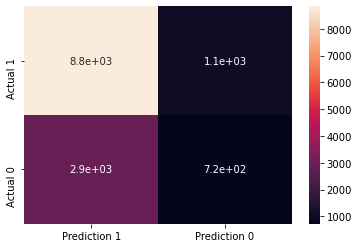

In [148]:
cm_lr_base = confusion_matrix(y_test, pred_lr_base, labels = [1,0])
df_lr_base = pd.DataFrame(data = cm_lr_base, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_lr_base, annot = True)
plt.show()

In [55]:
df_lr_base

,Prediction 1,Prediction 0
Actual 1,8839,1075
Actual 0,2884,725


In [56]:
pd.DataFrame(data=[accuracy_score(y_test, pred_lr_base), recall_score(y_test, pred_lr_base),
                   precision_score(y_test, pred_lr_base), roc_auc_score(y_test, pred_lr_base),
                   f1_score(y_test, pred_lr_base)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['LogReg Base'])

,LogReg Base
accuracy,0.707240
recall,0.891567
precision,0.753988
roc_auc_score,0.546227
f1_score,0.817026


In [57]:
pd.DataFrame(data = [lr_base.score(X_train, y_train), lr_base.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['LogReg Base'])

,LogReg Base
Train Score,0.731365
Test Score,0.732012


### Random Forest Base

In [39]:
rf_base = RandomForestClassifier()
rf_base.fit(X_train_sm, y_train_sm)

RandomForestClassifier()

In [40]:
pred_rf_base = rf_base.predict(X_test)

In [41]:
print(classification_report(y_test, pred_rf_base))

              precision    recall  f1-score   support

           0       0.36      0.30      0.33      3609
           1       0.76      0.81      0.78      9914

    accuracy                           0.67     13523
   macro avg       0.56      0.55      0.55     13523
weighted avg       0.65      0.67      0.66     13523



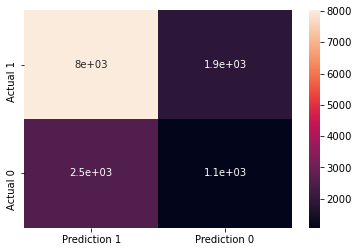

In [149]:
cm_rf_base = confusion_matrix(y_test, pred_rf_base, labels = [1,0])
df_rf_base = pd.DataFrame(data = cm_rf_base, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_rf_base, annot = True)
plt.show()

In [43]:
df_rf_base

,Prediction 1,Prediction 0
Actual 1,8025,1889
Actual 0,2538,1071


In [44]:
pd.DataFrame(data=[accuracy_score(y_test, pred_rf_base), recall_score(y_test, pred_rf_base),
                   precision_score(y_test, pred_rf_base), roc_auc_score(y_test, pred_rf_base),
                   f1_score(y_test, pred_rf_base)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['Random Forest Base'])

,Random Forest Base
accuracy,0.672632
recall,0.809461
precision,0.759727
roc_auc_score,0.553110
f1_score,0.783806


In [45]:
pd.DataFrame(data = [rf_base.score(X_train, y_train), rf_base.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['Random Forest Base'])

,Random Forest Base
Train Score,0.999908
Test Score,0.672632


### XGBoost Base

In [28]:
xg_base = GradientBoostingClassifier()
xg_base.fit(X_train_sm, y_train_sm)

GradientBoostingClassifier()

In [29]:
pred_xg_base = xg_base.predict(X_test)

In [30]:
print(classification_report(y_test, pred_xg_base))

              precision    recall  f1-score   support

           0       0.40      0.31      0.35      3609
           1       0.77      0.83      0.80      9914

    accuracy                           0.69     13523
   macro avg       0.58      0.57      0.57     13523
weighted avg       0.67      0.69      0.68     13523



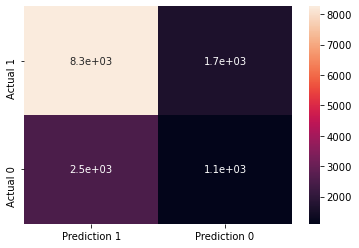

In [150]:
cm_xg_base = confusion_matrix(y_test, pred_xg_base, labels = [1,0])
df_xg_base = pd.DataFrame(data = cm_xg_base, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_xg_base, annot = True)
plt.show()

In [32]:
df_xg_base

,Prediction 1,Prediction 0
Actual 1,8260,1654
Actual 0,2506,1103


In [37]:
pd.DataFrame(data=[accuracy_score(y_test, pred_xg_base), recall_score(y_test, pred_xg_base),
                   precision_score(y_test, pred_xg_base), roc_auc_score(y_test, pred_xg_base),
                   f1_score(y_test, pred_xg_base)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['XGBoost Base'])

,XGBoost Base
accuracy,0.692376
recall,0.833165
precision,0.767230
roc_auc_score,0.569395
f1_score,0.798839


In [38]:
pd.DataFrame(data = [xg_base.score(X_train, y_train), xg_base.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['XGBoost Base'])

,XGBoost Base
Train Score,0.699105
Test Score,0.692376


### Logistic Regression Tuned

In [46]:
lr_base.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
lr_tune = LogisticRegression()
param_lr = {
    "C": [0.001, 0.01, 0.1, 1],
    "penalty": ['l1', 'l2', 'elasticnet', 'none'], 
    "max_iter": [10, 100, 1000]}

lr_gs = GridSearchCV(
    estimator = lr_tune, param_grid = param_lr, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

lr_gs.fit(X_train_sm_ro, y_train_sm)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:   17.4s finished


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': [10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none']},
             scoring='precision', verbose=1)

In [50]:
lr_gs.best_params_

{'C': 0.001, 'max_iter': 100, 'penalty': 'l2'}

In [58]:
pred_lr_tune = lr_gs.predict(X_test_ro)

In [59]:
print(classification_report(y_test, pred_lr_tune))

              precision    recall  f1-score   support

           0       0.37      0.32      0.34      3609
           1       0.76      0.80      0.78      9914

    accuracy                           0.67     13523
   macro avg       0.56      0.56      0.56     13523
weighted avg       0.66      0.67      0.66     13523



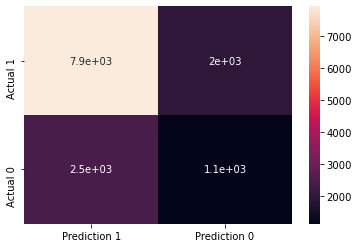

In [151]:
cm_lr_tune = confusion_matrix(y_test, pred_lr_tune, labels = [1,0])
df_lr_tune = pd.DataFrame(data = cm_lr_tune, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_lr_tune, annot = True)
plt.show()

In [61]:
df_lr_tune

,Prediction 1,Prediction 0
Actual 1,7941,1973
Actual 0,2466,1143


In [144]:
pd.DataFrame(data=[accuracy_score(y_test, pred_lr_tune), recall_score(y_test, pred_lr_tune),
                   precision_score(y_test, pred_lr_tune), roc_auc_score(y_test, pred_lr_tune),
                   f1_score(y_test, pred_lr_tune)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['LogReg Tune'])

,LogReg Tune
accuracy,0.671744
recall,0.800989
precision,0.763044
roc_auc_score,0.558848
f1_score,0.781556


In [64]:
pd.DataFrame(data = [lr_gs.score(X_train, y_train), lr_gs.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['LogReg Tune'])

,LogReg Tune
Train Score,0.734600
Test Score,0.734901


### Random Forest Tuned

In [65]:
rf_base.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [95]:
rf_tune = RandomForestClassifier()
param_rf = {
    "n_estimators": [10, 25, 50, 100],
    "max_depth": [None, 1, 5, 7, 10],
    "min_samples_leaf": np.linspace(0.05, 0.1, 10)}

rf_grid = GridSearchCV(
    estimator = rf_tune, param_grid = param_rf, cv = 5, n_jobs = -1, verbose = 1, scoring = 'precision')

rf_grid.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.8min finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 1, 5, 7, 10],
                         'min_samples_leaf': array([0.05      , 0.05555556, 0.06111111, 0.06666667, 0.07222222,
       0.07777778, 0.08333333, 0.08888889, 0.09444444, 0.1       ]),
                         'n_estimators': [10, 25, 50, 100]},
             scoring='precision', verbose=1)

In [96]:
rf_grid.best_params_

{'max_depth': 1, 'min_samples_leaf': 0.07777777777777778, 'n_estimators': 10}

In [97]:
pred_rf_tune = rf_grid.predict(X_test)

In [98]:
print(classification_report(y_test, pred_rf_tune))

              precision    recall  f1-score   support

           0       0.32      0.67      0.44      3609
           1       0.80      0.49      0.61      9914

    accuracy                           0.54     13523
   macro avg       0.56      0.58      0.52     13523
weighted avg       0.68      0.54      0.57     13523



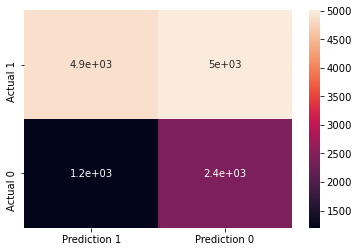

In [152]:
cm_rf_tune = confusion_matrix(y_test, pred_rf_tune, labels = [1,0])
df_rf_tune = pd.DataFrame(data = cm_rf_tune, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_rf_tune, annot = True)
plt.show()

In [100]:
df_rf_tune

,Prediction 1,Prediction 0
Actual 1,4904,5010
Actual 0,1197,2412


In [145]:
pd.DataFrame(data=[accuracy_score(y_test, pred_rf_tune), recall_score(y_test, pred_rf_tune),
                   precision_score(y_test, pred_rf_tune), roc_auc_score(y_test, pred_rf_tune),
                   f1_score(y_test, pred_rf_tune)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['Random Forest Tune'])

,Random Forest Tune
accuracy,0.541004
recall,0.494654
precision,0.803803
roc_auc_score,0.581492
f1_score,0.612426


In [103]:
pd.DataFrame(data = [rf_grid.score(X_train, y_train), rf_grid.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['Random Forest Tune'])

,Random Forest Tune
Train Score,0.801238
Test Score,0.803803


### XGBoost Tuned

In [104]:
xg_base.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [163]:
xg_tune = GradientBoostingClassifier()
param_xg = {
    "n_estimators" : [10, 20, 30, 50, 75, 100],
    "learning_rate" : np.linspace(0.05, 5, 20),
    "subsample" : [1, 0.1, 0.2, 0.5, 0.7]}

grid_xg = RandomizedSearchCV(
    estimator = xg_tune, param_distributions = param_xg, cv = 5, n_jobs = -1, verbose = 1, n_iter = 100, scoring = 'precision')

grid_xg.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.7min finished


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.05      , 0.31052632, 0.57105263, 0.83157895, 1.09210526,
       1.35263158, 1.61315789, 1.87368421, 2.13421053, 2.39473684,
       2.65526316, 2.91578947, 3.17631579, 3.43684211, 3.69736842,
       3.95789474, 4.21842105, 4.47894737, 4.73947368, 5.        ]),
                                        'n_estimators': [10, 20, 30, 50, 75,
                                                         100],
                                        'subsample': [1, 0.1, 0.2, 0.5, 0.7]},
                   scoring='precision', verbose=1)

In [164]:
grid_xg.best_params_

{'subsample': 0.7, 'n_estimators': 75, 'learning_rate': 1.092105263157895}

In [165]:
pred_xg_tune = grid_xg.predict(X_test)

In [166]:
print(classification_report(y_test, pred_xg_tune))

              precision    recall  f1-score   support

           0       0.40      0.26      0.32      3609
           1       0.76      0.86      0.81      9914

    accuracy                           0.70     13523
   macro avg       0.58      0.56      0.56     13523
weighted avg       0.67      0.70      0.68     13523



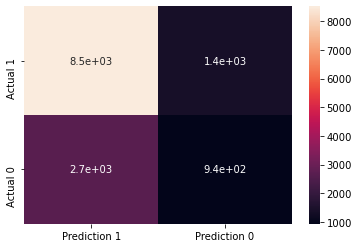

In [167]:
cm_xg_tune = confusion_matrix(y_test, pred_xg_tune, labels = [1,0])
df_xg_tune = pd.DataFrame(data = cm_xg_tune, columns=['Prediction 1','Prediction 0'],index=['Actual 1','Actual 0'])
sns.heatmap(df_xg_tune, annot = True)
plt.show()

In [168]:
df_xg_tune

,Prediction 1,Prediction 0
Actual 1,8522,1392
Actual 0,2674,935


In [169]:
pd.DataFrame(data=[accuracy_score(y_test, pred_xg_tune), recall_score(y_test, pred_xg_tune),
                   precision_score(y_test, pred_xg_tune), roc_auc_score(y_test, pred_xg_tune),
                   f1_score(y_test, pred_xg_tune)],index = ['accuracy', 'recall', 'precision', 'roc_auc_score', 'f1_score'],
             columns = ['XGBoost Tune'])

,XGBoost Tune
accuracy,0.699327
recall,0.859592
precision,0.761165
roc_auc_score,0.559334
f1_score,0.807390


In [170]:
pd.DataFrame(data = [grid_xg.score(X_train, y_train), grid_xg.score(X_test, y_test)],
             index = ['Train Score', 'Test Score'], columns = ['XGBoost Tune'])

,XGBoost Tune
Train Score,0.772320
Test Score,0.761165


### Evaluation Summary

In [171]:
acc_lr_base = accuracy_score(y_test, pred_lr_base)
acc_lr_tune = accuracy_score(y_test, pred_lr_tune)
acc_rf_base = accuracy_score(y_test, pred_rf_base)
acc_rf_tune = accuracy_score(y_test, pred_rf_tune)
acc_xg_base = accuracy_score(y_test, pred_xg_base)
acc_xg_tune = accuracy_score(y_test, pred_xg_tune)

prec_lr_base = precision_score(y_test, pred_lr_base)
prec_lr_tune = precision_score(y_test, pred_lr_tune)
prec_rf_base = precision_score(y_test, pred_rf_base)
prec_rf_tune = precision_score(y_test, pred_rf_tune)
prec_xg_base = precision_score(y_test, pred_xg_base)
prec_xg_tune = precision_score(y_test, pred_xg_tune)

rec_lr_base = recall_score(y_test, pred_lr_base)
rec_lr_tune = recall_score(y_test, pred_lr_tune)
rec_rf_base = recall_score(y_test, pred_rf_base)
rec_rf_tune = recall_score(y_test, pred_rf_tune)
rec_xg_base = recall_score(y_test, pred_xg_base)
rec_xg_tune = recall_score(y_test, pred_xg_tune)

f1_lr_base = f1_score(y_test, pred_lr_base)
f1_lr_tune = f1_score(y_test, pred_lr_tune)
f1_rf_base = f1_score(y_test, pred_rf_base)
f1_rf_tune = f1_score(y_test, pred_rf_tune)
f1_xg_base = f1_score(y_test, pred_xg_base)
f1_xg_tune = f1_score(y_test, pred_xg_tune)

In [172]:
summ = {
    'LogReg Base': [acc_lr_base, prec_lr_base, rec_lr_base, f1_lr_base],
    'LogReg Tune': [acc_lr_tune, prec_lr_tune, rec_lr_tune, f1_lr_tune],
    'Random Forest Base': [acc_rf_base, prec_rf_base, rec_rf_base, f1_rf_base],
    'Random Forest Tune': [acc_rf_tune, prec_rf_tune, rec_rf_tune, f1_rf_tune],
    'XGBoost Base': [acc_xg_base, prec_xg_base, rec_xg_base, f1_xg_base],
    'XGBoost Tune': [acc_xg_tune, prec_xg_tune, rec_xg_tune, f1_xg_tune]}
eva_sum = pd.DataFrame(data = summ, index = ['Accuracy', 'Precision', 'Recall', 'F1-Score'])
eva_sum

# Random Forest setelah tuning memiliki Precision Score tertinggi 0,8 (80%)

,LogReg Base,LogReg Tune,Random Forest Base,Random Forest Tune,XGBoost Base,XGBoost Tune
Accuracy,0.707240,0.671744,0.672632,0.541004,0.692376,0.699327
Precision,0.753988,0.763044,0.759727,0.803803,0.767230,0.761165
Recall,0.891567,0.800989,0.809461,0.494654,0.833165,0.859592
F1-Score,0.817026,0.781556,0.783806,0.612426,0.798839,0.807390


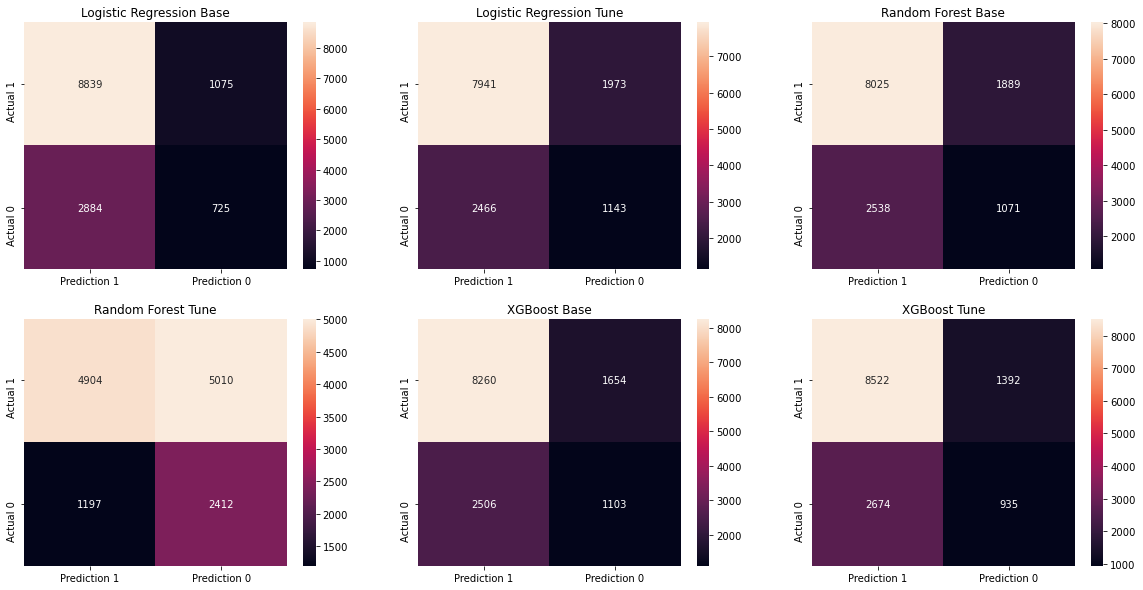

In [173]:
plt.figure(figsize=(20, 10))
plt.subplot(2,3,1)
sns.heatmap(df_lr_base, annot=True, fmt='d')
plt.title('Logistic Regression Base')

plt.subplot(2,3,2)
sns.heatmap(df_lr_tune, annot=True, fmt='d')
plt.title('Logistic Regression Tune')

plt.subplot(2,3,3)
sns.heatmap(df_rf_base, annot=True, fmt='d')
plt.title('Random Forest Base')

plt.subplot(2,3,4)
sns.heatmap(df_rf_tune, annot=True, fmt='d')
plt.title('Random Forest Tune')

plt.subplot(2,3,5)
sns.heatmap(df_xg_base, annot=True, fmt='d')
plt.title('XGBoost Base')

plt.subplot(2,3,6)
sns.heatmap(df_xg_tune, annot=True, fmt='d')
plt.title('XGBoost Tune')
plt.show()

# Random Forest setelah tuning memiliki nilai False Positive paling rendah (aktual charged off, prediksi fully paid)

In [119]:
rf_best = rf_grid.best_estimator_

In [123]:
joblib.dump(rf_best, 'rf_best.pkl')

['RF_best.pkl']

## Kesimpulan
1. 26,7% dari peminjam tidak melunasi pinjamanan, dibandingkan 73,3% yang lunas.
2. 75% jumlah pinjaman berada dalam range 100-250 ribu. Semakin besar jumlah pinjaman, semakin besar juga kemungkinan pinjaman tidak lunas.
3. 49% penghasilan tahunan peminjam berada di range 1-1,5 juta. Semakin besar penghasilan tahunan peminjam, semakin besar kemungkinan pinjaman lunas.
4. 64% peminjam memiliki riwayat kredit 15 tahun keatas. Semakin lama riwayat kredit peminjam, semakin besar kemungkinan pinjaman lunas.
5. Mayoritas pinjaman bersifat short term (74%) dibandingkan pinjaman long term (26%). Pinjaman berjangka panjang / long term (38%) lebih tinggi tingkat charged off dibanding short term (23%).
6. Mayoritas peminjam berada dalam kategori credit score Good 670-739 (76,5%), hanya 5,3% dalam kategori Fair 580-669. Persentase charged off di kategori credit score Good (29%), lebih rendah dari kategori Fair yang mencapai 43%. Semakin tinggi credit score peminjam semakin besar kemungkinan pinjaman lunas. 
7. Hampir setengah peminjam (49%) menjadikan rumahnya sebagai jaminan pinjaman, sedangkan 42% masih menyewa rumah. Peminjam yang menjaminkan rumahnya memiliki kemungkinan charged off (24%), lebih rendah dari yang menyewa rumah (30%)
8. Sebagian besar tujuan pinjaman adalah untuk konsolidasi hutang (79%).
9. Secara keseluruhan, indikasi suatu pinjaman tidak dilunasi memiliki faktor-faktor berikut: jumlah pinjaman diatas 500 ribu, penghasilan tahunan dibawah 500 ribu, credit history rendah, pinjaman jangka panjang, credit score fair dan peminjam masih menyewa rumah.
10. Model machine learning Random Forest setelah dilakukan hyperparameter tuning memiliki Precision Score 0,8 (80%) dan nilai False Positive paling rendah. Evaluation metric yang difokuskan adalah Precision Score karena yang diutamakan adalah meminimalisir False Positive (aktual charged off, tetapi diprediksi fully paid). Hal ini untuk menghindari resiko kerugian bank apabila peminjam tidak dapat melunasi pinjamannya.

## Rekomendasi
Model machine learning dapat diterapkan pada dashboard divisi peminjaman bank untuk membantu proses assessment pinjaman sebelum disetujui. Model akan melakukan klasifikasi antara peminjam yang akan melunasi pinjaman atau yang akan menjadi pinjaman gagal. Penggunaan machine learning dapat mempercepat proses assessment dan mengurangi resiko pinjaman yang tidak lunas.